In [0]:
import pandas as pd
import numpy as np
import re
import csv
from tqdm import tqdm
from collections import defaultdict, Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt
import random
from nltk.tokenize import WordPunctTokenizer

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv("/content/drive/My Drive/Books, learning materials/NLP/Manning/2_29_stackexchange_812k.tokenized.csv", low_memory=False, index_col=False)

In [38]:
df.head()

,Unnamed: 0,post_id,parent_id,comment_id,text,category,tokens,n_tokens
0,0,291254,NaN,601672.0,The condition makes the gradient unbiased. it ...,comment,the condition makes the gradient unbiased . it...,17
1,1,115372,NaN,221284.0,"Yes, that sounds fine to me.",comment,"yes , that sounds fine to me .",8
2,2,327356,NaN,NaN,Consider gaussian variables belonging to a gau...,post,consider gaussian variables belonging to a gau...,31
3,3,186923,NaN,355055.0,Thanks S. Catterall. - Integrability I knew th...,comment,thanks s . catterall . - integrability i knew ...,30
4,4,433143,NaN,NaN,Feature with very few extreme values,title,feature with very few extreme values,6


In [0]:
df['tokens'] = df.tokens.apply(lambda t : t.split())

In [40]:
df.head()

,Unnamed: 0,post_id,parent_id,comment_id,text,category,tokens,n_tokens
0,0,291254,NaN,601672.0,The condition makes the gradient unbiased. it ...,comment,"[the, condition, makes, the, gradient, unbiase...",17
1,1,115372,NaN,221284.0,"Yes, that sounds fine to me.",comment,"[yes, ,, that, sounds, fine, to, me, .]",8
2,2,327356,NaN,NaN,Consider gaussian variables belonging to a gau...,post,"[consider, gaussian, variables, belonging, to,...",31
3,3,186923,NaN,355055.0,Thanks S. Catterall. - Integrability I knew th...,comment,"[thanks, s, ., catterall, ., -, integrability,...",30
4,4,433143,NaN,NaN,Feature with very few extreme values,title,"[feature, with, very, few, extreme, values]",6


In [0]:
train_df = df.loc[df['category']=="title"]
test_df = df.loc[df['category']!="title"]

In [30]:
train_df.shape[0] # 83685
test_df.shape[0] # 705964
df.shape[0] # 789649 -- matches 

789649

In [42]:
counts = defaultdict(Counter)
ngrams_degree = 2
for tokens in tqdm(train_df['tokens'].values):
    for ngram in ngrams(
          tokens, 
          n= ngrams_degree,  
          pad_right=True, 
          pad_left=True, 
          left_pad_symbol="<s>", 
          right_pad_symbol="</s>"):
      
        prefix = ngram[:ngrams_degree-1]
        token = ngram[ngrams_degree-1]
        counts[prefix][token] +=1


100%|██████████| 83685/83685 [00:01<00:00, 61582.00it/s]


In [43]:
print("The number of bigrams is {}".format(len(counts.keys())))

The number of bigrams is 15752


In [0]:
tokens_count = [len(v)   for k,v in counts.items()]

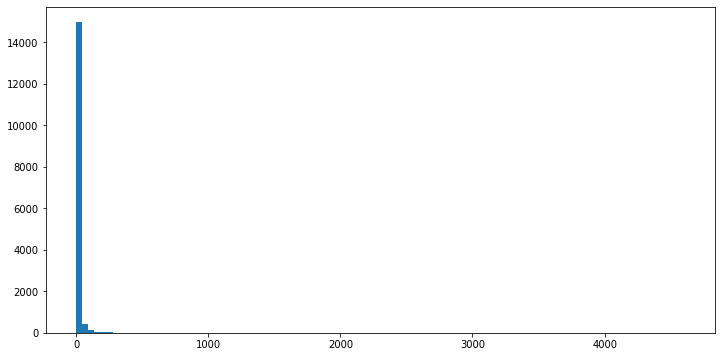

In [45]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
plt.hist(tokens_count, bins = 100);

In [46]:
bigrams_with_single_tokens = [ k   for k,v in counts.items() if len(v) == 1 ]
bigrams_with_two_tokens = [ k   for k,v in counts.items() if len(v) == 2 ]

print("{} bigrams_with_single_tokens".format(len(bigrams_with_single_tokens)))
print("{} bigrams_with_two_tokens".format(len(bigrams_with_two_tokens)))


7067 bigrams_with_single_tokens
2197 bigrams_with_two_tokens


In [47]:
tokens_dict = { k:len(v)   for k,v in counts.items() if len(v) > 10000 }
tokens_dict

{}

In [0]:
freq = defaultdict(dict)
for prefix, tokens in counts.items():
    total = sum( counts[prefix].values()  )
    for token, c in tokens.items():
        freq[prefix][token] = c / total


In [50]:
for i in range(5):
    prefix = random.choice(list(freq.keys()))
    print("{}: \t{}".format(prefix,freq[prefix]))

('exponentials',): 	{'?': 0.1111111111111111, 'in': 0.1111111111111111, 'suggest': 0.1111111111111111, '</s>': 0.3333333333333333, 'is': 0.1111111111111111, 'and': 0.1111111111111111, 'with': 0.1111111111111111}
('sv',): 	{'for': 0.25, 'occurs': 0.25, 'model': 0.25, 'in': 0.25}
('secure',): 	{'permission': 0.5, 'random': 0.5}
('protovis',): 	{'dot': 1.0}
('definate',): 	{'matrix': 1.0}


In [0]:
def generate_temp(text, temperature = 1, n_words=30):
    for i in range(n_words):
        prefix = tuple(text.split()[-ngrams_degree+1:])
        # no available next word
        if len(freq[prefix]) == 0:
            break
        candidates  = list(freq[prefix].keys())
        initial_probas = list(freq[prefix].values())
        # modify distribution
        denom   = sum( [ p ** temperature for p in initial_probas ] )
        probas  = [ p ** temperature / denom  for p in initial_probas  ]

        text       += ' ' + np.random.choice(candidates, p = probas)
        if text.endswith('</s>'):
            break

    return text


In [55]:
text  = 'the model'
# text  = 'to determine'
# text  = 'not sure'

for tau in [0.01, 0.5, 1, 3, 10]:
  print(tau)
  print(generate_temp(text, temperature = tau))



0.01
the model gets higher odds increase p variable amount in personal health of mardia skewness transformation into time mdps handled multicolinearity affect x e and gibbs distribution v s election results vs
0.5
the model anova assumption behind in error through different exams ? variance not agree with an inverse is moran scatterplot regions </s>
1
the model </s>
3
the model ? </s>
10
the model </s>


In [0]:


tokenizer = WordPunctTokenizer()


def perplexity(sentence):
    sentence = tokenizer.tokenize(sentence.lower())
    N = len(sentence)
    logprob = 0
    
    for ngram in ngrams(
          sentence, 
          n= ngrams_degree,  
          pad_right=True, pad_left=True, 
          left_pad_symbol="<s>", right_pad_symbol="</s>"):
        try:
          prefix = ngram[:ngrams_degree-1] 
          token = ngram[ngrams_degree-1]
          logprob += np.log( freq[ prefix ][token]  )
        except:
            pass

    return np.exp(- logprob / N)



In [57]:
sentence = "the difference between the two approaches is discussed here"
print("[perplexity {:.2f}] {}".format(perplexity(sentence), sentence))

sentence = "this question really belongs on a different site"
print()
print("[perplexity {:.2f}] {}".format(perplexity(sentence), sentence))

sentence = "The function may only be linear in the region where the points were taken"
print()
print("[perplexity {:.2f}] {}".format(perplexity(sentence), sentence))


[perplexity 24.09] the difference between the two approaches is discussed here

[perplexity 18.95] this question really belongs on a different site

[perplexity 96.71] The function may only be linear in the region where the points were taken


In [0]:
def perplexity_laplace(sentence,delta = 1):
    sentence = tokenizer.tokenize(sentence.lower())
    N = len(sentence)
    logprob = 0
    for ngram in ngrams(
          sentence, 
          n= ngrams_degree,  
          pad_right=True, pad_left=True, 
          left_pad_symbol="<s>", right_pad_symbol="</s>"):
        prefix = ngram[:ngrams_degree-1]
        token = ngram[ngrams_degree-1]
        if prefix in list(counts.keys()):
            total = sum( counts[prefix].values()  )
            if token in counts[prefix].keys():
                # normal calculation
                logprob += np.log( (counts[prefix][token] + delta)/ (total + delta * N ) )
            else:
                logprob += np.log( ( delta)/ (total + delta * N ) )
        else:
            logprob += - np.log( N )
  
    return np.exp(-logprob / N)



In [59]:
sentence = "this model belongs on a different planet"
print("[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 10), sentence))

sentence = "this question really belongs on a different site."
print("[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 10), sentence))


[perplexity 186.58] this model belongs on a different planet
[perplexity 98.88] this question really belongs on a different site.


In [60]:
sentence = "this model belongs on a different planet"
print("\n[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 1), sentence))

sentence = "this question really belongs on a different site."
print("\n[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 1), sentence))



[perplexity 485.17] this model belongs on a different planet

[perplexity 276.20] this question really belongs on a different site.


In [0]:
def logproba_sentence(sentence, delta = 1):
    sentence = tokenizer.tokenize(sentence.lower())
    logprob = 0
    for ngram in ngrams(
        sentence, n= ngrams_degree,  
        pad_right=True, pad_left=True, 
        left_pad_symbol="<s>", right_pad_symbol="</s>"):
        prefix = ngram[:ngrams_degree-1]
        token = ngram[ngrams_degree-1]
        try:
          logprob += np.log( freq[prefix][token] )
        except:
          pass

    return logprob



In [0]:
def corpus_perplexity(corpus):
  # start by calculating the total number of tokens in the corpus
  all_sentences = ' '.join(corpus)

  all_tokens =  tokenizer.tokenize(all_sentences.lower())
  N = len(tokens)

  logprob = 0
  for sentence in tqdm(corpus):
    logprob += logproba_sentence(sentence)

  return np.exp( - logprob / N)




In [64]:
# The perplexity of a sample of 1000 titles
corpus = test_df.text.sample(1000, random_state = 12).values
corpus_perplexity(corpus)

100%|██████████| 1000/1000 [00:00<00:00, 6376.25it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


inf

In [68]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [70]:
# from nltk.lm.preprocessing import padded_everygram_pipeline 
from nltk.lm import MLE
from nltk.lm import Vocabulary

train_data = [
    ngrams(t, n= ngrams_degree,
        pad_right=True, pad_left=True,
        left_pad_symbol="<s>", right_pad_symbol="</s>")
    for t in df_train.tokens.values]

words = [word for sent in df_train.tokens.values for word in sent]
words.extend(["<s>", "</s>"])
vocab = Vocabulary(words, unk_cutoff = 20)



ModuleNotFoundError: ignored

In [0]:
# define the model
model = MLE(ngrams_degree)

# fit the model
model.fit(train_data, vocab)

